# **From Zero to 2048: Building RL environment with JAX**

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*eFZKUHOG7Dte_0DJ8ORU5g.gif" width="50%" />

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** Omayma Mahjoub, Siddarth Singh, Wiem Khlifi, Jawhar Afli, and Ruan de Kock.

**Reviewers:** Ismael Kone

**Original Notebook:**
<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/RL_2048/From_Zero_to_2048_Building_RL_environment_with_JAX_(Beginner_Level).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

In this practical, we will explore building a JAX environment for the game "2048". In Reinforcement Learning (RL), the roles of an Agent and an Environment are crucial, as the environment is essential for testing and training RL algorithms. On the other side, JAX has become a key tool in advancing RL algorithm implementation, enabling more efficient architectures and the creation of distributed systems that can be trained in minutes on local GPU machines. However, to achieve this efficiency, the environment needs to be "jaxified". The importance of adapting environments for JAX is highlighted by the growing focus on jax-environments repositories like Jumanji, Gymnax, and JaxMARL.

During this practical, you will be introduced to the fundamentals of RL and Markov Decision Processes (MDP). We will use the 2048 game as an example to formulate an MDP, defining key components such as rewards, observations, and states. This hands-on exercise will help you understand these critical concepts in a practical context. You will also learn about the basic structure of an environment and related terms like "reset," "step," and "timestep".

The goal is not only to create this environment using JAX but also to compare JAX with traditional Python, highlighting differences in functionality, and logic. By the end of this practical, you will have foundational skills in modeling problems or games as MDPs and will serve as an entry into programming environments with JAX.

**Topics:**

Content: Reinforcement Learning

Level:  <font color='blue'>`Beginner`</font>


**Prerequisites:**

* Some familiarity with [JAX](https://github.com/google/jax).
* Neural network basics.

**Before you start:**

For this practical, in case you are using colab, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

# Installation and Downloads

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Practical setup (Run this cell first)
import sys
import subprocess
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

def is_running_in_colab():
    return 'google.colab' in sys.modules

def install_packages():
    print("Installing Packages...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "-U",
                           "jumanji[train] @ git+https://github.com/instadeepai/jumanji.git@main"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet",
                           "imageio==2.34.2"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet",
                           "pygame==2.6.0"])

if is_running_in_colab():
    print("Running in Google Colab.")
    install_packages()
else:
    print("Not running in Google Colab.")
    try:
        # Try to get the IPython shell
        ipython = get_ipython()

        if ipython is not None and hasattr(ipython, 'run_cell_magic'):
            ipython.run_cell_magic('capture', '', 'install_packages()')
        else:
            raise AttributeError("IPython shell doesn't support run_cell_magic")

    except NameError:  # get_ipython() is not defined
        install_packages()
    except AttributeError:  # IPython shell doesn't support run_cell_magic
        install_packages()

import io
import os
import pickle

import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from huggingface_hub import hf_hub_download
from hydra import compose, initialize
from IPython.display import Image, display, clear_output
from jax import grad, jit, vmap
from jumanji import specs
from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device
from jumanji.types import TimeStep, restart, termination, transition, StepType
from jumanji.environments.logic.game_2048.viewer import Game2048Viewer
from jumanji.viewer import Viewer
from jumanji.env import Environment
from tqdm import notebook
import random
import pygame
from pygame.locals import *
from chex import Array, Numeric, PRNGKey
from typing_extensions import TypeAlias
#"State" and "Observation" are implemented as NamedTuple.
from typing import NamedTuple, Tuple, Optional, Sequence

%matplotlib notebook

def download_file(url: str, file_path: str) -> None:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print("Failed to download the file.")


def download_jumanji_agent(
    env_name: str, model_checkpoint_dir: str = "trained_policy_checkpoint"
):
    os.makedirs("configs", exist_ok=True)
    config_url = "https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/config.yaml"
    download_file(config_url, "configs/config.yaml")
    env_url = f"https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/env/{env_name}.yaml"
    os.makedirs("configs/env", exist_ok=True)
    download_file(env_url, f"configs/env/{env_name}.yaml")
    with initialize(version_base=None, config_path="configs"):
        cfg = compose(
            config_name="config.yaml", overrides=[f"env={env_name}", f"agent=a2c"]
        )
    # Chose the corresponding checkpoint from the InstaDeep Model Hub
    # https://huggingface.co/InstaDeepAI
    REPO_ID = f"InstaDeepAI/jumanji-benchmark-a2c-{cfg.env.registered_version}"
    FILENAME = f"{cfg.env.registered_version}_training_state"
    model_checkpoint = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

    # Load the checkpoint data
    with open(model_checkpoint, "rb") as f:
        training_state = pickle.load(f)

    # Save the loaded training state
    with open(model_checkpoint_dir, "wb") as f:
        pickle.dump(training_state, f)


# We also run the code that will pull the jumanji agent and setup the configs
download_jumanji_agent(env_name="game_2048")

Running in Google Colab.
Installing Packages...


Game2048-v1_training_state:   0%|          | 0.00/600k [00:00<?, ?B/s]

In [ ]:
# @title Helper functions and imports (Run this cell before starting the practical)

import io
import os
import pickle

import warnings

import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from huggingface_hub import hf_hub_download
from hydra import compose, initialize
from IPython.display import Image, display, clear_output
from jax import grad, jit, vmap
from jumanji import specs
from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device
from jumanji.types import TimeStep, restart, termination, transition, StepType
from jumanji.environments.logic.game_2048.viewer import Game2048Viewer
from jumanji.viewer import Viewer
from jumanji.env import Environment
from tqdm import notebook
import random
import pygame
from pygame.locals import *
from chex import Array, Numeric, PRNGKey
from typing_extensions import TypeAlias
#"State" and "Observation" are implemented as NamedTuple.
from typing import NamedTuple, Tuple, Optional, Sequence

# suppress all warnings
warnings.filterwarnings("ignore")

%matplotlib notebook

def rollout_and_render_policy(
    env_name: str,
    agent_name: str,
    model_checkpoint_dir: str = "trained_policy_checkpoint",
):
    with open(model_checkpoint_dir, "rb") as f:
        training_state = pickle.load(f)

    with initialize(version_base=None, config_path="configs"):
        cfg = compose(
            config_name="config.yaml",
            overrides=[f"env={env_name}", f"agent={agent_name}"],
        )

    params = first_from_device(training_state.params_state.params)
    env = setup_env(cfg).unwrapped
    agent = setup_agent(cfg, env)
    if agent_name == "a2c":
        policy = jax.jit(agent.make_policy(params.actor, stochastic=False))
    else:
        # don't need params for a random agent
        policy = jax.jit(agent.make_policy(None, stochastic=False))

    NUM_EPISODES = 2

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    states = []
    key = jax.random.PRNGKey(cfg.seed)
    for episode in range(NUM_EPISODES):
        key, reset_key = jax.random.split(key)
        state, timestep = reset_fn(reset_key)
        states.append(state)
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(
                lambda x: x[None], timestep.observation
            )
            if agent_name == "a2c":
                action, _ = policy(observation, action_key)
            else:
                action = policy(observation, action_key)
            state, timestep = step_fn(state, action.squeeze(axis=0))
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(3):
            states.append(state)

    # Generate and store a gif of the policy
    gif_path = f"animation_{env_name}_{agent_name}.gif"
    env.animate(states, interval=150, save_path=gif_path)

    # Display the generated GIF
    display(Image(filename=gif_path))

# 1. From Theory to Practice: MDPs and 2048 Environment Design

## 1.1 Markov Decision Process (MDP)


>**To understand how we can train an AI to play the 2048 game, we need to introduce the concept of a Markov Decision Process (MDP). An MDP is a mathematical framework used to describe sequential decision making systems, where outcomes are partly random and partly under the control of a decision-maker.**

### **What is an MDP?** 🤔

An MDP consists of the following components:


<font size=8> $\langle \color{orange}{S}, \color{blue}{A}, \color{purple}{P}, \color{green}{R}, \color{black}{\gamma}\rangle$  </font>


*  $ \color{orange}{S}$  (state space) - represents all valid configurations of your environment i.e. what can your environment look like.  
*  $\color{blue}{A}$ (action space)   - represents all valid actions i.e. what your agents can do.  
*  $\color{purple}{P}$ (transition function)   - this tells you what is the likelihood of transitioning into a new state, given you are in a specific state and take an action ->  $s_{t+1}=P(s_t, a_t)$
*  $\color{green}{R}$ (reward function)  - tells us how good your current state and action pair is -> $r_t = R(s_t,a_t)$
*  $\color{black}{\gamma}$ (discount factor)   - term that controls the weighting between how much we value future rewards vs immediate rewards.

## 1.2 Let's Break Down MDP for 2048!

>**What is Game 2048? 🎮** 2048 is a popular single-player puzzle game that is played on a 4x4 grid. The game board consists of cells, each containing a power of 2, and the objective is to reach a score of at least 2048 by merging cells together. The player can shift the entire grid in one of the four directions (up ⬆️, down ⬇️, right ➡️, left ⬅️) to combine cells of the same value. When two adjacent cells have the same value, they merge into a single cell with a value equal to the sum of the two cells.
The game ends when the player is no longer able to make any further moves. The ultimate goal 🏆 is to achieve the highest-valued tile possible, with the hope of surpassing 2048. With each move, the player must carefully plan and strategize to reach the highest score possible.

### a) States 🏙️


> *State is a complete description of the state of the world (the environment).*

In the 2048 game, a state represents the current configuration of the game board. The game board is a 4x4 grid where each cell can be empty or contain a tile with a value that is a power of 2. Each unique arrangement of tiles on the board is a different state.

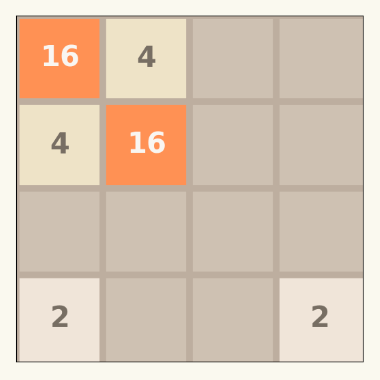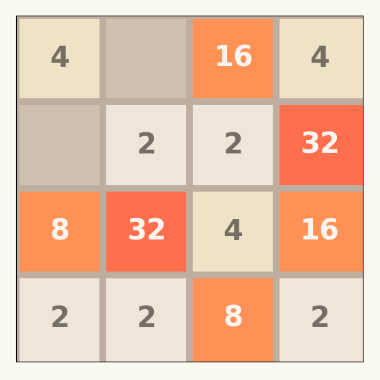

**Representing the Game Board with Arrays:**

In the 2048 game, the board can be represented as a 4x4 array (if size_board=4) where each cell contains either a power of 2 (representing a tile) or 0 (representing an empty cell). This array representation allows easy manipulation and calculation of the game state. For example to represent the above board state (the one on the left) we have:

```python
[16,  4,  0,  0]
[ 4, 16,  0,  0]
[ 0,  0,  0,  0]
[ 2,  0,  0,  2]
```





### b) Actions 🎮


>*The Action space is the set of all possible actions that the agents can act in the environment.*

In the game of 2048, the **actions** are the moves you can make:
  - **Up ⬆️**
  - **Down ⬇️**
  - **Left ⬅️**
  - **Right ➡️**

Each action causes the tiles on the board to slide in the corresponding direction and merge if they have the same value.

🕹️ To make these movements, the agent decides on a number that corresponds to one of the actions:
0: Move Up ⬆️
1: Move Right ➡️
2: Move Down ⬇️
3: Move Left ⬅️.
The agent's decision on which number to choose dictates the direction in which the tiles on the board will move.

###c) Transition Probabilities 🎲

>*Transition probabilities tell us how likely it is to move from one state to another after taking an action.*

In the 2048 game, this includes:
  - How the tiles move and merge (which is deterministic).
  - Where the new tile (usually a 2 or sometimes a 4) appears after each move (which is random).


###d) Rewards 🏆

> *In an MDP, rewards are feedback signals received from the environment after taking an action in a state, indicating the immediate benefit of that action.*

   The **reward** helps us understand the immediate benefit of an action. For the game of 2048, It can be defined based on the following points:
   
* **Combining Tiles:** When two tiles combine, they form a new tile with a value that is the sum of the two original tiles. This combination process is crucial to the game’s progress. Therefore, a good reward function should give a positive reward for each combination, reflecting the new tile’s value. For example, combining two tiles of 2 to form a 4 could give a reward of 4.

* **Game Progress:** The main goal is to reach the 2048 tile, but until then, the higher the tiles you create, the better. Hence, each combination should reward the agent based on the value of the new tile created. The reward can be directly proportional to the tile value.

  
  For example, if a player merges two 512-value tiles to create a new 1024-value tile, and at the same time merges two 256-value tiles to create a new 512-value tile, the total reward from these actions is 1536 (i.e., 1024 + 512).

  This reward function encourages the agent to make moves that combine tiles and create higher-value tiles, ultimately working towards the goal of creating the 2048 tile.

  >⚠️ Note: The reward function is not unique, and there might be other reward strategies that could work effectively.
  </details></h5>

## 1.3 Summary: The MDP for 2048 🧩

To sum up, the 2048 game as an MDP looks like this:
- **State (s)**: The 4x4 grid representing the game board.
- **Action (a)**: One of {Up ⬆️, Down ⬇️, Left ⬅️, Right ➡️}.
- **Transition Probability (P(s'|s, a))**: Deterministic for the move, stochastic for the new tile placement.
- **Reward (R(s, a))**: The score obtained from merging tiles.

By defining the 2048 game as an MDP, we can use reinforcement learning algorithms to train an AI agent to play the game and aim for the highest score possible! 🎉


## 1.4 Translating some MDP Concepts into Code for 2048: Types definition

### a) Managing the 2048 Game State 🕹️

To effectively manage the environment state in the 2048 game, we need to store several key components:

1. **Board** 🎲: Represents the current state of the game board.
2. **Random Key** 🔑: Used for any stochastic operations, such as sampling a new tile's location and value.
3. **Action Mask** 🎭: A binary array indicating which actions are legal at the current state.
4. **Step Count** ⏳: Tracks the number of steps taken in the current episode. Helps in terminating the episode when the predefined horizon is reached.
5. **Score** 🏅: Accumulates the cumulative reward, showcasing the player's progress and performance in the game.


To encapsulate this information, we define the `State` and `Observation` classes as follows:

In [ ]:
Board: TypeAlias = Array

class State(NamedTuple):
    board: Board
    step_count: Numeric
    action_mask: Array
    key: PRNGKey
    score: Numeric

class Observation(NamedTuple):
    board: Board
    action_mask: Array

### b) Agent-Environment Interaction 🌐

- **Timestep ⏱️**: A single point in time within the game where the agent interacts with the environment. Think of it as a snapshot 📸 in a photo album, capturing a specific moment in the ongoing process.
- **Episode Stages 🔄🛑🔀**: Includes restart (initial state), termination (end state), and transition (moving between states).

To encapsulate these concepts, we define the `TimeStep` class as follows:

```python
@dataclass
class TimeStep(Generic[Observation]):
    step_type: StepType  # Type of the step (restart, transition, or termination)
    reward: Array  # Reward received at this timestep
    discount: Array  # Discount factor for future rewards
    observation: Observation  # Observation made at this timestep
    extras: Dict = field(default_factory=dict)  # Any additional information
```

# 2. Utility Functions Implementation for 2048





To effectively simulate the 2048 game environment, we need to implement several utility functions that handle key operations within the game. These functions will be essential for managing the game state, performing movements, merging tiles, and introducing new random tiles. Let's break down the implementation of these critical utility functions:

1. **Generating a Random Cell:** This function will add a new tile to the board, usually a 2 or occasionally a 4, at a random empty position.

2. **Generating the Initial Board:** This function will initialize the game board at the start of a game, typically by placing two random tiles on the board

3. **Merging Tiles:** This function will handle the merging of tiles when they are moved in the same direction and have the same value.

4. **Board Movement:** This set of functions will handle the shifting of tiles in the four possible directions (up, down, left, right) and manage the overall movement logic of the game.

These functions' utility can be illustrated in the following figure where the agent decide to move right ➡

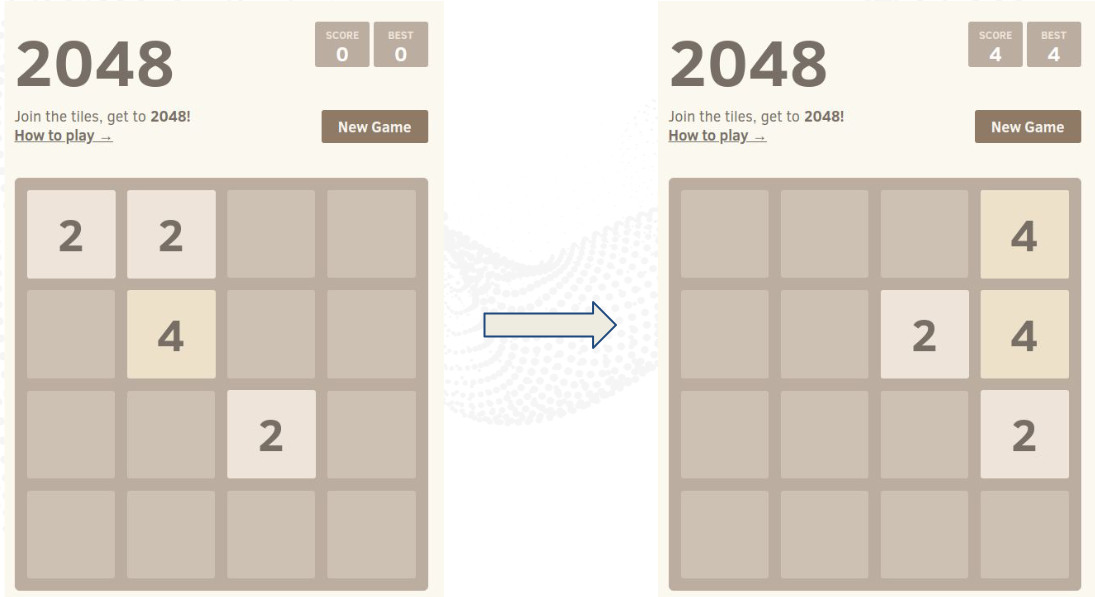

## 2.1 Random cell



>**In 2048 game environment, every time you make a move, a new cell magically appears in an empty spot on the grid!**

### 🎲 How Does It Work? 🎲

Here's the secret sauce:

  **🔄 Each Step:** After each interaction with the environment, a new cell pops up in one of the empty spots.
  
 **🧮 Probability Details:**

*   There's a 90% chance (🟢 0.9) that the new cell will be a 2.
* And a 10% chance (🔴 0.1) that it will be a 4.

###🛠️ Initial Implementation Plan 🛠️


Here's the simple plan to get it done:

  **🕵️‍♂️ Find Empty Spots:** Get the index of all empty spots on the grid.
  
  **🎯 Choose Random Spot:** Randomly select one of these indices.

  **🎲 Choose Value:** Randomly decide whether the new cell will be a 2 or a 4 based on their probabilities.

  **✨ Update Grid:** Change the value of the grid at the chosen index to the new value.

### 💻Coding time 💻

Let's dive into the code to see this magic in action:

In [ ]:
def add_random_cell(board: Board, key: PRNGKey) -> Board:

    # Generate a new key
    key, subkey = jax.random.split(key)

    # Select position of the new random cell
    zero_indices = jnp.argwhere(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(zero_indices))
    )

    # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )

    board = board.at[tuple(zero_indices[tile_idx])].set(cell_value)

    return board

Here's a quick breakdown of the magic behind the scenes:

1. 🎲 We start by generating a new key for randomness using `jax.random.split`, ensuring each step is unpredictable.
2. 🔍 Using `jnp.argwhere`, we find all the empty spots on the board – our blank canvases.
3. 🎯 We then use `jax.random.choice` to randomly select one of these empty spots.
4. 🎲 Another `jax.random.choice` determines whether the new cell will be a 2 or a 4, with probabilities of 90% and 10% respectively.
5. ✨ Finally, we place the new cell on the board with `board.at[index].set(value)`.

Now, let's test our `add_random_cell` function to see it in action. We'll start with a predefined board and add a random cell to it:

In [ ]:
# Test add_random_cell
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(1)
board=add_random_cell(board, key)
print(board)

[[ 2  2  0  2]
 [ 4  8 16  0]
 [16  0 32  0]
 [32 64  0 64]]


**🚀 JIT Compilation in JAX 🚀**

One of the powerful features of JAX is Just-In-Time (JIT) compilation. JIT can make your functions run much faster by compiling them to machine code, leveraging hardware acceleration, and optimizing repeated operations. Using JIT is simple: just decorate your function with `jax.jit`.

Let's put this to the test by applying JIT to our random cell utility function and see the performance boost in action. Ready, set, JIT! 🏎️💨✨

In [ ]:
# Jitted method
try:
  board=jnp.array(
      [
          [ 2,  2,  0,  0],
          [ 4,  8, 16,  0],
          [16,  0, 32,  0],
          [32, 64,  0, 64]
      ]
  )
  key=jax.random.PRNGKey(0)
  add_random_cell_jit = jax.jit(add_random_cell)
  board = add_random_cell_jit(board, key)
  print(board)
except Exception as e:
  print(f"An error occurred: {e}")

An error occurred: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function add_random_cell at <ipython-input-10-9ed82fe2d974>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument board.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError



####😱 Uh-oh, JIT Compilation Failed!

It looks like our attempt to JIT compile the random cell utility function hit a snag 🛑.

**What's the deal?**

Jitted functions choke on non-static variables, like arrays, because their size isn’t known at compile time. This makes it tricky for the compiler to generate efficient code for handling them.

Here’s the technical scoop:

*   Non-static variables: Their size is only determined at runtime.
*   JIT Compiler: Prefers to know sizes upfront for optimal performance.

This dynamic allocation is why our jitted function couldn’t handle the variable effectively, specifically, our use of `jnp.argwhere` is causing the issue because it produces an array whose size vary based on how many empty cells in the board.  But fear not, there's always a workaround!

#####**Exercise 2: Find an Alternative Solution! 🧩**
Our initial plan using `jnp.argwhere` won't work with JIT compilation. Your task is to find an alternative way to identify empty spots on the board (with static array) and re-implement the add_random_cell function that is capable to be jitted. Fill in the missing parts of the code cell provided below.


<h5><details>
  <summary>🔽 <b>Hint 1: Idea to Solve the Non-static Array Issue</b> 🔽</summary>
Flatten the matrix of the board. It will be easier to deal with a 1D array than a 2D array when it comes to choosing a random position. Since we can't use argwhere, change the matrix values to boolean (True if the cell is empty, and False if not) and use random.choice, but add probabilities associated with each cell.

After getting the random position of the new cell in the 1D array, translate it back to the 2D board.

</details></h5>
<h5><details>
  <summary>🔽 <b>Hint 2: Flatten the Array</b> 🔽</summary>
Use `jnp.ravel` to flatten the board matrix into a 1D array.

</details></h5>
<h5><details>
  <summary>🔽 <b>Hint 3: Find Empty Spots</b> 🔽</summary>
Use `jnp.ravel(board == 0)` to find the empty spots and then use `random.choice` with `p` to focus only on the empty spots.

</details></h5>

In [ ]:
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    # Generate a new key
    key, subkey = jax.random.split(key)

    # Select position of the new random cell
    # How it was before:
    #  zero_indices = jnp.argwhere(board == 0)
    #  tile_idx = jax.random.choice(key, jax.arange(len(zero_indices)))
    arr_1d=jnp.ravel(board)
    is_empty_arr=(arr_1d==0)
    tile_idx=jax.random.choice(
        key, jnp.arange(len(is_empty_arr)), p=is_empty_arr
    )
    position = jnp.divmod(tile_idx, board.shape[0])

    # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[position].set(cell_value)

    return board

In [ ]:
# @title 🕹️ Let's test your code!

def test_add_random_cell(add_random_cell_fn):
    try:
        # Sample board before adding a random cell
        board = jnp.array(
            [
                [2,  2,  0,  0],
                [4,  8, 16,  0],
                [16, 0, 32, 0],
                [32, 64, 0, 64]
            ]
        )
        # Random key for stochastic operations
        key = jax.random.PRNGKey(0)

        # Jitted method for adding a random cell
        add_random_cell_jit = jax.jit(add_random_cell_fn)

        # Adding a random cell to the board
        new_board = add_random_cell_jit(board, key)

        # Check if the function ran without errors
        assert new_board is not None, "The function did not return a valid board. Please check your implementation."

        # Check if exactly one zero has been replaced by 2 or 4
        num_zeros_before = jnp.sum(board == 0)
        num_zeros_after = jnp.sum(new_board == 0)
        num_new_tiles = num_zeros_before - num_zeros_after
        unique_values = jnp.unique(new_board)

        assert num_new_tiles == 1, "It looks like your code needs a bit of work. There should be exactly one new tile."
        assert any(tile in unique_values for tile in [2, 4]), "The new tile should be either 2 or 4."
        print("Nice! Your answer looks correct.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Test the add_random_cell function
test_add_random_cell(add_random_cell)


Nice! Your answer looks correct.


In [ ]:
# @title Solution
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    # Generate a new key
    key, subkey = jax.random.split(key)

    # Select position of the new random cell
    empty_flatten_board = jnp.ravel(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
    )
    # Convert the selected tile's location in the flattened array to its position on the board.
    board_size=board.shape[0]
    position = jnp.divmod(tile_idx, board_size)

    # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[position].set(cell_value)

    return board

# Jitted method
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(0)
add_random_cell_jit = jax.jit(add_random_cell)
board = add_random_cell_jit(board, key)
print(board)

[[ 2  2  4  0]
 [ 4  8 16  0]
 [16  0 32  0]
 [32 64  0 64]]


## 2.2 Generate the Initial Board


>**Let's create the starting point for our 2048 game! This function will generate an initial game board for our environment. The board will start empty, and then we'll fill one random cell with a value of 2 or 4.**

### 🛠️ Implementation Plan 🛠️

**1.   Create Empty Board:** Generate a board filled with zeros, with a specified size `board_size`.

**2.   Fill Random Cell:** Use our add_random_cell function to place a 2 or 4 in one random cell.

### 💻 Coding Time 💻


In [ ]:
def generate_board(board_size: int, key: PRNGKey) -> Board:
    # Create empty board
    board = jnp.zeros((board_size, board_size), dtype=jnp.int32)

    # Fill one random cell with a value of 2 or 4
    board = add_random_cell(board, key)

    return board

**🧪 Let's Test It! 🧪**

Now, let's test our generate_board function to see it in action. We'll generate a 4x4 board and fill one random cell:

In [ ]:
# Test generate_board
board_size = 4
key = jax.random.PRNGKey(0)
initial_board = generate_board(board_size, key)
print(initial_board)

[[0 0 4 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


## 2.3 Board Movements and Element Merging Strategies

###**a) Shift up a Column**

>**To shift all non-zero elements of a column to the top while maintaining their order and filling the remaining positions with zeros, we can follow a straightforward approach.**

Let's see how it works with an example:

**Original Array:**
```python
[[0],
 [2],
 [0],
 [2]]
```

**Shifted Column:**
```python
[[2],
 [2],
 [0],
 [0]]

```

####🛠️ Implementation Plan 🛠️


**1.  Shift Non-Zero Elements:**

*  *`i` (Iterator Index):* Moves through each element of the column.

*  *`j` (Next Free Position Index):* Tracks the next position for a non-zero element.

-> *Process:* As `i` inspects each element, if it's non-zero, it's moved to position `j`. `j` is then incremented.

**2.  Fill Remaining Positions with Zeros:**

*Process:* After all non-zero elements are positioned, start from `j` and fill all further positions with zeros until the column end.

<h5><details>
  <summary>🔽 <b>Click Here for a Concise Step-by-Step Example</b> 🔽</summary>

Initial Array: `[0, 2, 0, 2]`

**Process Overview:**

*  `i` (Iterator Index): Moves through each element of the column.

*  `j` (Next Free Position Index): Tracks the next position for a non-zero element.

**Steps:**

*  At index 1: The element is 2. It's moved to the position `j` (starts at 0), and `j` is incremented.

*  At index 3: Another 2 is encountered and moved to the next available position `j` (now 1), and `j` is incremented again.

-> This results in  `[2, 2, 0, 2]` and `j` equal to 2.

**Post-Shifting:**

*  Fill Zeros: Positions from `j` onward (starting at index 2) are set to zero.
Resulting Array: `[2, 2, 0, 0]`

</details></h5>

####💻 Coding Time 💻



In [ ]:
def shift_up(col: Array) -> Array:
    # Initialize a pointer to keep track of the next position to insert a non-zero element
    j = 0

    # Iterate over the array and place all non-zero elements to the left
    for i in range(len(col)):
        if col[i] != 0:
            col = col.at[j].set(col[i])  # Place non-zero at the next free position
            j += 1 # Prepare next position

    # Fill the remaining positions with zeros
    while j < len(col):
        col = col.at[j].set(0)
        j += 1

    return col



**🧪 Let's Test It! 🧪**

Let's test our `shift_up` function with a sample column:

In [ ]:
# Test shift_up
board_col = jnp.array([0, 2, 0, 2])
updated_col = shift_up(board_col)
print(updated_col)

[2 2 0 0]


####🚀JIT Compilation Challenge 🚀

When we try to JIT compile this function, we might run into issues because Jitted functions can't handle certain types of dynamic operations like variable-sized data structures or control flow statements (if statements and while loops).

**Why?**

Jitted functions require knowing the sizes upfront for optimal performance, which is tricky with dynamic allocations.

In [ ]:
# Test jitting shift_up
try:
  board_col = jnp.array([0, 2, 0, 2])
  shift_up_jit = jax.jit(shift_up)
  updated_col = shift_up_jit(board_col)
  print(updated_col)
except Exception as e:
  print(f"An error occurred: {e}")

An error occurred: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function shift_up at <ipython-input-20-948658798a0b>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument col.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError


####🛠️ Solution Using jax.lax 🛠️
We can use the jax.lax module, which provides low-level operations for building high-performance numerical computations.

*  `if` statement: `jax.lax.cond(condition, true_fn, false_fn, vars)`

* `while` loop: `jax.lax.while_loop(cond_fn, body_fn, init_val)`

* `for` loop: `jax.lax.scan(f, init, xs)`

Let's modify our function to use jax.lax for JIT compatibility!

**i) `jax.lax.cond`**


`jax.lax.cond` allows us to execute one of two branches of code based on a condition, similar to an if-else statement but designed to be JIT-compatible.

Original code:
```python
if col[i] != 0:
  col = col.at[j].set(col[i])
  j += 1
```
Converted code:




In [ ]:
def shift_nonzero_element(carry: Tuple) -> Tuple[Array, int]:
    """True function definition"""
    # Unpack the tuple to get the column, current insertion index, and the index of the element to check
    col, j, i = carry

    # Set the value at the current insertion index to the value of the element at index i
    col = col.at[j].set(col[i])

    # Increment the insertion index for the next potential non-zero element
    j += 1

    return col, j

def shift_column_elements_up(carry: Tuple, i: int) -> Tuple[Array, None]:
    # Unpack the tuple to get the current column and the insertion index
    col, j = carry

    # Conditionally shift the non-zero element at index i to the insertion index
    # If the element at index i is zero, just pass the current state through
    col, j = jax.lax.cond(
        col[i] != 0, # condition
        shift_nonzero_element, # true_fn
        lambda col_j_i: col_j_i[:2], # false_fn
        (col, j, i) # vars
    )

    return (col, j), None

**ii) `jax.lax.scan`**

`jax.lax.scan` is used for iterating over a sequence, similar to a for-loop, but it returns the final state and all intermediate states, making it suitable for operations like shifting elements in an array.

Original code:
```python
for i in range(len(col)):
    if col[i] != 0:
        col = col.at[j].set(col[i])
        j += 1
```
Converted code:


In [ ]:
def shift_up(col: Array) -> Array:
    # Initialize the insertion index to zero
    j = 0

    # Scan through the column, shifting non-zero elements upwards
    # `shift_column_elements_up` is applied to each element index in the column
    (col, j), _ = jax.lax.scan(
        f=shift_column_elements_up, # fn: the first input is the init vars and second input is a slice of xs which is in our case `i`.
        init=(col, j), # init vars
        xs=jnp.arange(len(col)) # xs: list to loop over its elements
    )

    # Fill the remaining positions with zeros
    #while j < len(col):
    #    col = col.at[j].set(0)
    #    j += 1
    return col

📌 Where the output is a tuple: the first element `(col, j)` which is represents the final loop carry value and the second element `_` represents the stacked outputs of the second output of `shift_column_elements_up` fn.

**iii) `jax.lax.while_loop`**

`jax.lax.while_loop` is used for executing a loop with a condition, similar to a while-loop.

Original code:
```python
while j < len(col):
    col = col.at[j].set(0)
    j += 1
```
Converted code:

In [ ]:
def fill_with_zero(carry: Tuple[Array, int]) -> Tuple[Array, int]:
    """Define bofy_fn of the while loop"""
    # Unpack the tuple to get the current column and the insertion index
    col, j = carry

    # Set the current position j in the column to zero
    col = col.at[j].set(0)

    # Increment the insertion index to move to the next position
    j += 1

    return col, j

def shift_up(col: Array) -> Array:
    # Initialize the insertion index to zero
    j = 0

    # Scan through the column, shifting non-zero elements upwards
    (col, j), _ = jax.lax.scan(
        f=shift_column_elements_up,
        init=(col, j),
        xs=jnp.arange(len(col))
    )

    # After all non-zero elements are shifted up, fill the remaining positions with zeros
    # This while loop continues until all positions from j to the end of the column are set to zero
    col, j = jax.lax.while_loop(
        lambda col_j: col_j[1] < len(col_j[0]), # condition function
        fill_with_zero, # body_fn (true_fn)
        (col, j) #init_vars
    )

    return col

🏎️ Let's Test Jitting! 🏎️

Let's test our new version of `shift_up` function with a sample column:

In [ ]:
board_col = jnp.array([0, 2, 0, 2])
shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print(updated_col)

[2 2 0 0]


### **b) Merging Elements**  

>**In the 2048 game environment, you can combine adjacent equal elements of a column. For example, `[0, 0, 2, 2]` can be merged to produce `[0, 0, 4, 0]`.**

####🎲 How Does It Work? 🎲


Here's the step-by-step plan:

*  **🕵️‍♂️ Check for Equal Adjacent Elements:** Iterate through the column to check for adjacent elements that are equal and not zero.

* **🎯 Merge Elements:** When two adjacent elements are equal:
  * Merge them by doubling the value of the first element and setting the second element to zero.
  * Add the value of the merged element to the reward.

#### 💻Coding time 💻

**Step 1: Merging Elements**

First, we define a function `merge_elements` to handle the merging of two equal adjacent elements. This function will double the value of the first element and set the second element to zero while updating the reward.

In [ ]:
def merge_elements(carry: Tuple[jnp.ndarray, float, int]) -> Tuple[jnp.ndarray, float]:
    col, reward, i = carry  # Unpack the input tuple into the column, current reward, and index
    new_col_i = 2 * col[i]  # Double the value of the element at index i
    col = col.at[i].set(new_col_i)  # Set the doubled value at index i
    col = col.at[i + 1].set(0)  # Set the value at index i + 1 to zero
    reward += new_col_i  # Add the value of the merged element to the reward
    return col, reward

**Step 2: Checking for Equal Adjacent Elements**

Next, we define a function `merge_equal_elements` that uses `jax.lax.cond` to check if the current element and the next element are equal and not zero. If they are, it calls merge_elements.

In [ ]:
def merge_equal_elements(carry: Tuple[jnp.ndarray, float], i: int) -> Tuple[Tuple[jnp.ndarray, float], None]:
    col, reward = carry
    col, reward = jax.lax.cond(
        (col[i] != 0) & (col[i] == col[i + 1]),  # Condition: elements at index i and i+1 are equal and not zero
        merge_elements,  # Function to call if the condition is true
        lambda col_reward_i: col_reward_i[:2],  # Function to call if the condition is false (pass through)
        (col, reward, i),
    )
    return (col, reward), None


**Step 3: Iterating Through the Column**

Finally, we use `jax.lax.scan` to iterate through the column and apply `merge_equal_elements` to each pair of adjacent elements.


In [ ]:
@jax.jit
def merge_col(col: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    reward = 0.0
    elements_indices = jnp.arange(len(col) - 1)
    (col, reward), _ = jax.lax.scan(
        f=merge_equal_elements, init=(col, reward), xs=elements_indices
    )
    return col, reward

**🧪 Let's Test It! 🧪**

In [ ]:
print("Initial column: ",board_col)

shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print("After shifting the elements: ",updated_col)

updated_col = merge_col(updated_col)

print("After merging equal elements: ",updated_col[0], "with a reward equals: ",updated_col[1])

Initial column:  [0 2 0 2]
After shifting the elements:  [2 2 0 0]
After merging equal elements:  [4 0 0 0] with a reward equals:  4.0


### **c) Different Movements**


>**We need to implement the movements for the 2048 game: up, down, left, and right.**

####🎲 How Does It Work? 🎲


*  **🕵️‍♂️ Shifting Elements Up:** Use the `shift_up` function to shift all non-zero elements to the top of the column.
* **🎯 Merging Elements:** Use the `merge_col` function to merge adjacent equal elements.
* **🔄 Shifting Elements Up Again:** Use the `shift_up` function again to shift the elements after merging.

####💻Coding time 💻

**Step 1: Moving Up a Column**

We'll define a function move_up_col to handle the movement of a single column. This function will shift the elements up, merge them, and then shift them up again.

In [ ]:
def move_up_col(carry: Tuple[jnp.ndarray, float], c: int) -> Tuple[Tuple[jnp.ndarray, float], None]:
    board, additional_reward = carry
    col = board[:, c]
    col = shift_up(col)  # In example: [4, 4, 2, 2] -> [4, 4, 2, 2]
    col, reward = merge_col(col)  # In example: [4, 4, 2, 2] -> [8, 0, 4, 0]
    col = shift_up(col)  # In example: [8, 0, 4, 0] -> [8, 4, 0, 0]
    additional_reward += reward
    return (board.at[:, c].set(col), additional_reward), None

**Step 2: Moving Up the full Board's cells**

We'll define a function `move_up` to handle the movement of all columns in the board. This function will use `jax.lax.scan` to apply `move_up_col` to each column.

In [ ]:
@jax.jit
def move_up(board: Board) -> Tuple[Board, float]:
    """Move up."""
    additional_reward = 0.0 # Initialize the reward to zero
    col_indices = jnp.arange(board.shape[0])  # Board of size 4 -> [0, 1, 2, 3]


    (board, additional_reward), _ = jax.lax.scan(
        f=move_up_col,
        init=(board, additional_reward),
        xs=col_indices,
    )
    return board, additional_reward


**Step 3: Moving Down, Left, and Right**

We'll define functions for moving down, left, and right. These functions will use the move_up function by rotating or flipping the board appropriately.

In [ ]:
def move_down(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Move down."""
    board, additional_reward = move_up(
        board=jnp.flip(board, 0)
    )
    return jnp.flip(board, 0), additional_reward

def move_left(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Move left."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=-1)
    )
    return jnp.rot90(board, k=1), additional_reward

def move_right(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Move right."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=1)
    )
    return jnp.rot90(board, k=-1), additional_reward

**🔥Now let's try to make an action up on the board🔥**


In [ ]:
board = jnp.array([
    [4, 2, 2, 0],
    [4, 8, 2, 4],
    [4, 8, 2, 4],
    [4, 8, 0, 0]
  ])
board, reward = move_up(board)
print("After moving up: \n",board,"\n Reward: ",reward )

After moving up: 
 [[ 8  2  4  8]
 [ 8 16  2  0]
 [ 0  8  0  0]
 [ 0  0  0  0]] 
 Reward:  44.0


# 3. Environment Implementation


>**Now let's discover the `Game2048` class of the 2048 game environment, with its cool and varied methods for easily initialising the game board, adding new tiles and managing the agent's movements.**

## 3.1 Overview of the `Game2048` Class 🕹️🎮



We're now going to take a peek at the various methods that are useful for our game 🤓:

### **a) Core Functions in any Environment**


1. **`__init__(self,)`** 🛠️

``` python
class Game2048(Environment[State]):

    def __init__(self, board_size: int = 4, env_viewer: Optional[Game2048Viewer] = None) -> None:
      """ Initializes the game environment"""
        self.board_size = board_size
        # Create viewer used for rendering
        self._env_viewer = env_viewer or Game2048Viewer("2048", board_size)
```

   - **Purpose:** Initializes the game environment.
   - **Details:** Configures the game board with the specified size and optionally sets up a viewer for rendering. If no viewer is provided, a default `Game2048Viewer` is used to visualize the game.

2. **`reset()`** 🔄

``` python
    def reset(self, key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        """Resets the environment."""
        pass
```

   - **Purpose:** Resets the environment to its initial state.
   - **Details:** Generates a new game board, initializes the action mask, and returns a `State` object along with a `TimeStep`. The `TimeStep` includes the initial observation, reward (usually zero), and other relevant information as described the previous section.

3. **`step()`** ▶️

```python
def step(self, state: State, action) -> Tuple[State, TimeStep[Observation]]:
        """Updates the environment state after the agent takes an action."""
        pass
```
   - **Purpose:** Updates the environment based on the agent's action.
   - **Details:** Applies the chosen action (Up, Right, Down, Left) to the board, updates the state, and generates a new observation for the agent. Returns the updated `State` and `TimeStep`. Determines if the episode is done or not.

### **b) Util functions**

4. **`_generate_board()`** 🏁
```python
def _generate_board(self, key: PRNGKey) -> Board:
        """Generates an initial board for the environment."""
        pass
```
   - **Purpose:** Generates the initial board configuration.
   - **Details:** Creates an empty board and places one random cell with a value of 2 or 4 to start the game.



5. **`_add_random_cell()`** 🎲


```python
 def _add_random_cell(self, board: Board, key: PRNGKey) -> Board:
        """Adds a new random cell to the board."""
          pass

```


   - **Purpose:** Adds a new random cell to the board.
   - **Details:** Chooses a random empty position on the board and sets it to either 2 (90% probability) or 4 (10% probability).

6. **`_get_action_mask(self, board: Board) -> Array`** 🚫


```python
def _get_action_mask(self, board: Board) -> Array:
        """Generates an action mask. """
        pass

```


   - **Purpose:** Generates a mask indicating which actions are valid.
   - **Details:** Evaluates which actions (Up, Right, Down, Left) will alter the board state. The action mask is a binary array where `0` indicates an invalid action and `1` indicates a valid action. Actions are considered valid if they result in a change to the board; otherwise, they are deemed illegal.


### **c) Spec functions**

7. **`observation_spec()`** 👁️🔍


```python
def observation_spec(self) -> specs.Spec:
      """Specifications of the observation of the `Game2048` environment."""
        pass
```


   - **Purpose:** Defines the specification for observations in the environment.
   - **Details:** Returns a `Spec` object from the `jumanji` library, which extends the `dm_env.spec.Array`. This object details the shape and type of the observation, including the game board and action mask, with methods like `self.name`, `self.generate_value`, and `self.validate`.


8. **`action_spec()`** 🎯


```python
def action_spec(self) -> specs.DiscreteArray:
        """Returns the action spec."""
         pass
```


   - **Purpose:** Specifies the action space for the environment.
   - **Details:** Returns a `DiscreteArray` that defines the four possible actions as discrete values:
     - `0` -> **Up** ⬆️
     - `1` -> **Right** ➡️
     - `2` -> **Down** ⬇️
     - `3` -> **Left** ⬅️
   - This array represents the actions the agent can take to manipulate the game board.


### **d) Rendering functions**

9. **`render()`** 🎨


```python
    def render(self, state: State, save: bool, path: str) -> None:
        """Renders the current state of the game board."""
        pass

   
```


   - **Purpose:** Renders the current state of the game board.
   - **Details:** Uses the viewer to create a visual representation of the board and optionally saves it to a file.

10. **`animate()`** 🎥

```python
 def animate(self, states: Sequence[State]) -> None:
        """Creates an animated gif of the 2048 game board based on the sequence of game states."""
        pass
```

  - **Purpose:** Creates an animated GIF of the game.
  - **Details:** Generates an animation showing the sequence of game states over time, with customizable interval and save options.


## 3.2 Full implementation with details 💪

### **a) Understanding the `reset` method ♻️**



To reset an environment imagine pressing the reset button on your game console 🎮. The environment starts with a new fresh state ensuring everything is in place and ready for a new round of interaction 🏋.




env_reset.drawio.svg

Step by step pipeline for the `reset` function:
1. **Initialize the board 🏁:** Sets up a new board with a random tile to kickstart the game.
2. **Generate the action mask 🎭:** Creates a binary array that indicates which actions are valid and which are not.
3. **Return the initial state and observation 🎬:** Provides the starting state for the agent, including the initial board configuration and valid actions.

In the implementation below, the `reset()` method utilizes two utility methods `_generate_board`(defined in [section 2](https://colab.research.google.com/drive/1CtpkKhO-wTBNhiyOTIUItkuuAF8zcbXw?authuser=5#scrollTo=9rM2_oq5l1yW) ) and `_get_action_mask`.

In [ ]:
def reset(key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
    """Resets the environment."""

    # Split the key to create randomness for board initialization.
    key, board_key = jax.random.split(key)

    # Generate the initial board with a random tile.
    board = self._generate_board(board_key)

    # Get the action mask indicating valid actions.
    action_mask = self._get_action_mask(board)

    # Create the initial observation.
    obs = Observation(board=board, action_mask=action_mask)

    # Create a TimeStep object marking the start of a new episode.
    timestep = restart(observation=obs)

    # Create the initial state of the environment.
    state = State(
        board=board,
        step_count=jnp.int32(0),
        action_mask=action_mask,
        key=key,
        score=jnp.array(0, float),
    )
    return state, timestep


### **b)_get_action_mask method 🎭**

**Exercise 3: Define the Action Mask for Valid Moves**

In this exercise, you'll implement the `_get_action_mask` method. This method generates a binary mask indicating which actions are valid based on the current state of the game board. An action is considered valid if it results in a change in the board state.

</details></h5>
<h5><details>
  <summary>🔽 <b>Hint1 </b> 🔽</summary>
Check if any of the actions (move up, move right, move down, move left) change the board state.

</details></h5>
<h5><details>
  <summary>🔽 <b>Hint2 </b> 🔽</summary>
Use jnp.any to verify if an action results in a different board state

In [ ]:
def _get_action_mask(board: Board) -> Array:
    """Generates a binary mask indicating which actions are valid. """
    action_mask = ... # Guess the logic to determine valid actions based on the current state.
    return action_mask


In [ ]:
# @title 🕹️ Let's test your code!

def test_get_action_mask(get_action_mask_fn):
    try:
        # Sample board states
        board1 = jnp.array(
            [
                [2, 2, 0, 0],
                [4, 8, 16, 0],
                [16, 0, 32, 0],
                [32, 64, 0, 64]
            ]
        )
        board2 = jnp.array(
            [
                [4, 2, 4, 2],
                [4, 2, 4, 2],
                [4, 2, 4, 2],
                [4, 2, 4, 2]
            ]
        )
        expected_mask1 = jnp.array([True, True, True, True])
        expected_mask2 = jnp.array([True, False, True, False])

        # Test the function with sample boards
        mask1 = get_action_mask_fn(board1)
        mask2 = get_action_mask_fn(board2)

        assert jnp.array_equal(mask1, expected_mask1), f"Test failed for board1: expected {expected_mask1}, got {mask1}"
        assert jnp.array_equal(mask2, expected_mask2), f"Test failed for board2: expected {expected_mask2}, got {mask2}"

        print("Nice! Your answer looks correct.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Test the _get_action_mask function
test_get_action_mask(lambda board: _get_action_mask(board))


In [ ]:
# @title Solution

def _get_action_mask(board: Board) -> Array:
        """Generates a binary mask indicating which actions are valid. """
        action_mask = jnp.array(
            [
                jnp.any(move_up(board)[0] != board),
                jnp.any(move_right(board)[0] != board),
                jnp.any(move_down(board)[0] != board),
                jnp.any(move_left(board)[0] != board),
            ],
        )
        return action_mask

### **c) Understanding the step method ➡️**


The **`step`** method updates the environment state based on the agent's action. It is typically called at every step of an episode. This function handles the game's core mechanics⭐, including:

1. **Applying the Agent's Action** ▶️: The function processes the action (Up, Right, Down, Left) chosen by the agent, updating the board accordingly.
2. **Updates the action mask 🎭**: Indicates which actions are valid after the move.
3. **Checking for Game Over** 🛑: The function checks if the game is over, either by reaching the 2048 tile or by having no valid moves left.
4. **Adds a new random tile 🆕**: Places a new tile on the board unless the game is over..
5. **Returns the new state and observation 👀**: Provides the updated state and feedback(reward) to the agent. Rewards 🏅 are awarded for good moves, particularly when tiles are successfully merged, which is usually the sum of the values of the merged tiles.

In the example below, two tiles with the same number (2) touch during a move and merge into a single tile with a value equal to the sum of the two tiles (2+2=4 -> reward=4).




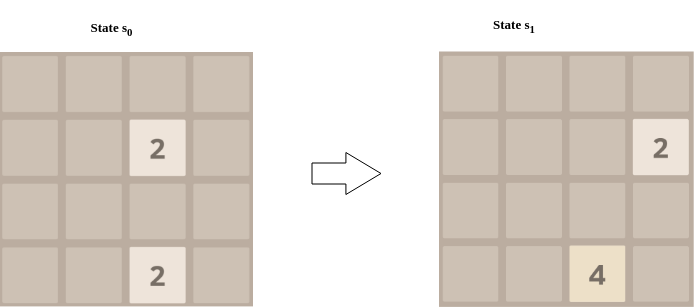

**Exercice 4: Define the `step` Function**

Fill in the missing parts of the step function to implement the game's core mechanics.

In [ ]:
def step(state: State, action) -> Tuple[State, TimeStep[Observation]]:
    """Updates the environment state after the agent takes an action."""

    # Apply the action to update the board: lax.switch is appling exactly one of the branches given by index.
    updated_board, additional_reward = jax.lax.switch(
        action,  # The action chosen by the agent (0: Up, 1: Right, 2: Down, 3: Left)
        [move_up, move_right, move_down, move_left],  # List of functions to call based on the action
        state.board,  # The current state of the board
    )

    # Generate action mask.
    action_mask = _get_action_mask(board=updated_board)

    # Check if the episode terminates (i.e. there are no legal actions).
    done = ~jnp.any(action_mask)

    # Generate new key.
    random_cell_key, new_state_key = jax.random.split(state.key)

    # Update the state of the board by adding a new random cell unless the game is over.
    updated_board = jax.lax.cond(
        done,
        lambda board, pkey: board,
        _add_random_cell,
        updated_board,
        random_cell_key,
    )
    # Build the state.
    state = State(
        board=updated_board,
        action_mask=action_mask,
        step_count=state.step_count + 1,
        key=new_state_key,
        score=state.score + additional_reward.astype(float),
    )
    # Generate the observation from the environment state.
    observation = Observation( board=updated_board, action_mask=action_mask)

    # Return either a MID or a LAST timestep depending on done.
    timestep = jax.lax.cond(
        done,
        termination,
        transition,
        additional_reward,
        observation,
    )
    return state, timestep

### **d) Full `Game2048` implementation 🎉**

🎉 Finally, the grand reveal of our game! 🎉

In this part, you'll witness the magic of all the methods and pieces we've introduced coming together in perfect harmony. Think of it as the grand finale of a fireworks show, where everything just clicks and dazzles! Get ready to see how all the moving parts work together to create the ultimate 2048 game experience! 🚀✨

In [ ]:
class Game2048(Environment[State, specs.DiscreteArray, Observation]):

    def __init__(self, board_size: int = 4, env_viewer: Optional[Game2048Viewer] = None) -> None:
        """ Initializes the game environment with a specified board size and an optional viewer for rendering."""
        self.board_size = board_size
        # Create viewer used for rendering
        self._env_viewer = env_viewer or Game2048Viewer("2048", board_size)

    def __repr__(self) -> str:
        """String representation of the environment."""
        return f"2048 Game(board_size={self.board_size})"

    def reset(self, key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        """Resets the environment."""

        key, board_key = jax.random.split(key)
        board = self._generate_board(board_key)
        action_mask = self._get_action_mask(board)

        obs = Observation(board=board, action_mask=action_mask)
        timestep = restart(observation=obs)

        state = State(
            board=board,
            step_count=jnp.int32(0),
            action_mask=action_mask,
            key=key,
            score=jnp.array(0, float),
        )
        return state, timestep

    def step(self, state: State, action) -> Tuple[State, TimeStep[Observation]]:
        """Updates the environment state after the agent takes an action."""

        # Take the action in the environment: Up, Right, Down, Left.
        updated_board, additional_reward = jax.lax.switch(
            action,
            [move_up, move_right, move_down, move_left],
            state.board,
        )

        # Generate action mask to keep in the state for the next step and
        # to provide to the agent in the observation.
        action_mask = self._get_action_mask(board=updated_board)

        # Check if the episode terminates (i.e. there are no legal actions).
        done = ~jnp.any(action_mask)

        # Generate new key.
        random_cell_key, new_state_key = jax.random.split(state.key)

        # Update the state of the board by adding a new random cell.
        updated_board = jax.lax.cond(
            done,
            lambda board, pkey: board,
            self._add_random_cell,
            updated_board,
            random_cell_key,
        )
        # Build the state.
        state = State(
            board=updated_board,
            action_mask=action_mask,
            step_count=state.step_count + 1,
            key=new_state_key,
            score=state.score + additional_reward.astype(float),
        )
        # Generate the observation from the environment state.
        observation = Observation( board=updated_board, action_mask=action_mask)

        # Return either a MID or a LAST timestep depending on done.
        timestep = jax.lax.cond(
            done,
            termination,
            transition,
            additional_reward,
            observation,
        )
        return state, timestep

    def _generate_board(self, key: PRNGKey) -> Board:
        """Generates an initial board for the environment."""

        # Create empty board
        board = jnp.zeros((self.board_size, self.board_size), dtype=jnp.int32)

        # Fill one random cell with a value of 2 or 4
        board = self._add_random_cell(board, key)

        return board

    def _add_random_cell(self, board: Board, key: PRNGKey) -> Board:
        """Adds a new random cell to the board."""
        key, subkey = jax.random.split(key)

        # Select position of the new random cell
        empty_flatten_board = jnp.ravel(board == 0)
        tile_idx = jax.random.choice(
            key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
        )
        # Convert the selected tile's location in the flattened array to its position on the board.
        position = jnp.divmod(tile_idx, self.board_size)

        # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
        cell_value = jax.random.choice(
            subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
        )
        board = board.at[position].set(cell_value)

        return board

    def _get_action_mask(self, board: Board) -> Array:
        """Generates a binary mask indicating which actions are valid. """
        action_mask = jnp.array(
            [
                jnp.any(move_up(board)[0] != board),
                jnp.any(move_right(board)[0] != board),
                jnp.any(move_down(board)[0] != board),
                jnp.any(move_left(board)[0] != board),
            ],
        )
        return action_mask

    def observation_spec(self) -> specs.Spec:
      """Specifications of the observation of the `Game2048` environment."""
      return specs.Spec(
          Observation,
          "ObservationSpec",
          board=specs.Array(
              shape=(self.board_size, self.board_size),
              dtype=jnp.int32,
              name="board",
          ),
          action_mask=specs.BoundedArray(
              shape=(4,),
              dtype=bool,
              minimum=False,
              maximum=True,
              name="action_mask",
          ),
      )

    def action_spec(self) -> specs.DiscreteArray:
        """Returns the action spec."""
        return specs.DiscreteArray(4, name="action")

    def render(self, state: State, save: bool = True, path: str = "./2048.png") -> None:
        """Renders the current state of the game board."""
        self._env_viewer.render(state=state, save=save, path=path)

    def animate(
        self,
        states: Sequence[State],
        interval: int = 200,
        save_path: Optional[str] = None,
    ):
        """Creates an animated gif of the 2048 game board based on the sequence of game states."""
        return self._env_viewer.animate(
            states=states, interval=interval, save_path=save_path
        )

# 4. Random Agent & Rendering

## 4.1 Rendering Random Agent

Before an RL agent has learnt anything in its environment, it will behave randomly. Using some utility functions that are provided by InstaDeep's [Jumanji](https://github.com/instadeepai/jumanji) library, we can visualise what a random agent's behaviour in the 2048 game looks like.

Let's give it a shot!

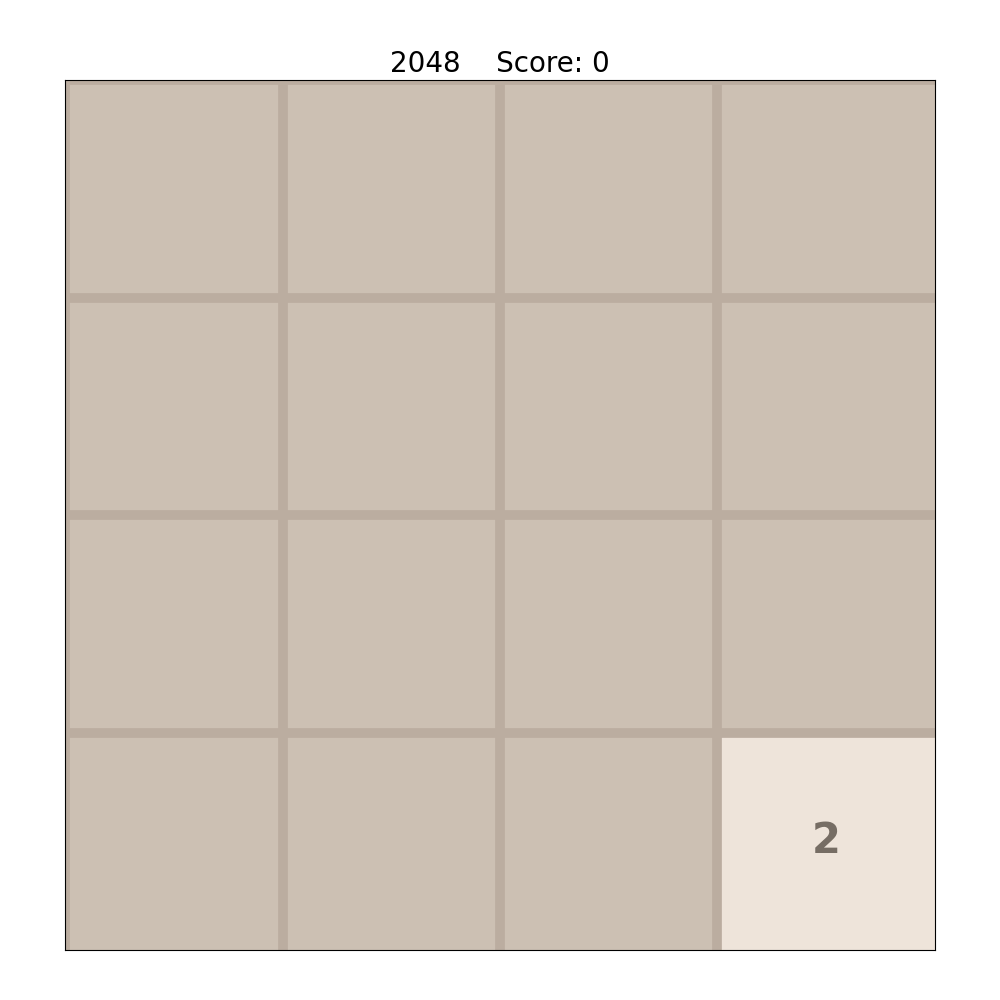

In [ ]:
rollout_and_render_policy(env_name="game_2048", agent_name="random")

## 4.2 (Optional) Using the Game2048 Environment: interaction with Random Agent

>**This is the behind of the scene for section 4.1. Here, we'll outline the process of using this environment to train an agent, starting with the initial reset and proceeding through steps until the game ends.**

### **Step 1: Resetting the Environment**


Before the agent can start interacting with the environment, we need to reset the environment to its initial state.

In [ ]:
# Initialize the environment
game2048 = Game2048(board_size=4)

# Generate a random key for the environment
key = jax.random.PRNGKey(0)

# Reset the environment to get the initial state and timestep
state, timestep = game2048.reset(key)

# Print the initial state and timestep
print("Initial State:", state)
print("Initial Timestep:", timestep)

### **Step 2: Performing Actions in the Environment**

The agent interacts with the environment by selecting actions and updating the state through the step function.

In [ ]:
# Initialize a list to store the states for later visualization
states = [state]

# Variable to accumulate the total reward
total_reward = jnp.float32(0)

# Interaction loop until the game ends
while not timestep.last():
    # Split the key for randomness in action selection
    action_key, key = jax.random.split(key)

    # Randomly select an action based on the action mask
    action = jax.random.choice(action_key, jnp.arange(4), p=state.action_mask.flatten())

    # Take the action and update the state and timestep
    state, timestep = game2048.step(state, action)

    # Accumulate the reward
    total_reward += timestep.reward

    # Store the state for visualization
    states.append(state)

# Print the total reward after the game ends
print("Total Reward:", total_reward)

### **Step 3: Visualizing the game**

After the interaction loop ends, we can visualize the gameplay using the animate method:
  * states: is a list of `State` objects representing the sequence of game states.
  * interval: the delay between frames in milliseconds

In [ ]:
game2048.animate(states=states, interval=400)

# Conclusion
**Summary:**

In this practical, we delved into the fundamentals of reinforcement learning (RL) using the 2048 game as our environment. We explored the key components of RL, including states, actions, rewards, and transitions, and saw how these elements come together to form a Markov Decision Process (MDP). Through hands-on exercises, we learned how to implement the 2048 environment using JAX, from generating the initial game board to managing game state and interactions. We also saw how to design utility functions such as shifting columns, merging elements, and adding random cells to the board.

By implementing and testing these functions, we gained a deeper understanding of how to model and simulate an RL environment. Additionally, we demonstrated the interaction loop between an RL agent and the environment, highlighting the process of state updates and reward accumulation. Finally, we visualized the agent's performance using animations to see the agent's progression through the game.

**Finished Early!**

If you finished this practical, we recommend you to give a look to the intermediate level version of this practical (click [here](https://github.com/deep-learning-indaba/indaba-pracs-2024/blob/faaacd0058c0a9d38cfd4d2ab1d18c7cf11c5a8a/practicals/From_Zero_to_2048_Building_RL_environment_with_JAX_(Intermediate_Level).ipynb))!

**Next Steps:**

Having mastered the environment, the next step is to learn about the agent:

- The most infuential textbook on RL - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).

* DLI RL Prac 2023: [Frozen Lake: An Icy Adventure using Reinforcement Learning!](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/RL_2023_prac.ipynb)





**References:**

* [DLI RL Prac 2023: Frozen Lake: An Icy Adventure using Reinforcement Learning!](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/RL_2023_prac.ipynb)

* [Jumanji: A diverse suite of scalable reinforcement learning environments in JAX](https://github.com/instadeepai/jumanji)
  * [Game_2048](https://github.com/instadeepai/jumanji/tree/main/jumanji/environments/logic/game_2048)

* [IndabaX TN 2023:Building 2048 environment using Jax!](https://github.com/instadeepai/IndabaX-TN-2023-RL)

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).

# Feedback
Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

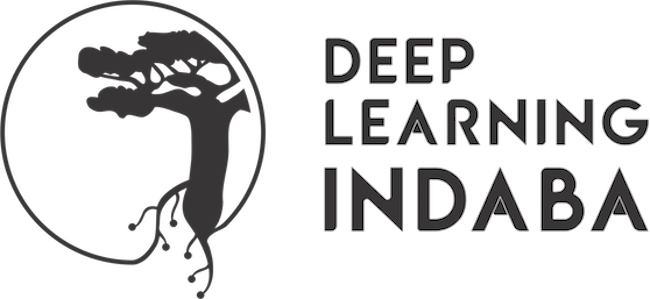